# EDA
Here I will explore relationships between the different features in my data.

**imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import os
import sys

sys.path.append("./util_")
import prepare_
import explore_

# set a default them for all my visuals
sns.set_theme(style="whitegrid")

**get data**

In [2]:
# load vehicle data
vehicle = prepare_.get_vehicle_data_no_dummies()

Original dataframe size: (2004974, 30)
New dataframe size: (2004974, 24)


**split data**

In [3]:
train, validate, test = prepare_.split_data_(vehicle, test_size=0.2, stratify_col="fatality", random_state=95 )
(train.shape, validate.shape, test.shape)

((1202984, 24), (400995, 24), (400995, 24))

In [4]:
train.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,fatality
728700,2018-01-13,2023-07-08 17:05:00,QUEENS,11422,40.656616,-73.744965,UNKNOWN,UNKNOWN,147-26 BROOKVILLE BOULEVARD,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,SEDAN,SEDAN,UNKNOWN,UNKNOWN,UNKNOWN,0
470214,2019-02-27,2023-07-08 17:50:00,QUEENS,11417,40.672783,-73.843250,UNKNOWN,UNKNOWN,135-45 CROSS BAY BOULEVARD,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,STATION_WAGON,STATION_WAGON,UNKNOWN,UNKNOWN,UNKNOWN,0
1356648,2015-03-31,2023-07-08 03:30:00,BROOKLYN,11211,40.708426,-73.957904,BROADWAY,MARCY AVENUE,UNKNOWN,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,LIVERY_VEHICLE,PASSENGER_VEHICLE,UNKNOWN,UNKNOWN,UNKNOWN,0
1903801,2012-08-08,2023-07-08 18:30:00,MANHATTAN,10007,40.713135,-74.004058,CENTRE STREET,CHAMBERS STREET,UNKNOWN,0,...,Driver Fatigue and Inattention,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,PICKUP_TRUCK,PASSENGER_VEHICLE,UNKNOWN,UNKNOWN,UNKNOWN,0
1731955,2013-06-13,2023-07-08 12:10:00,BROOKLYN,11212,40.671924,-73.904516,GLENMORE AVENUE,POWELL STREET,UNKNOWN,0,...,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,Uncertain or Unspecified Factors,PASSENGER_VEHICLE,PASSENGER_VEHICLE,UNKNOWN,UNKNOWN,UNKNOWN,0


## Univariate Stats

In [5]:
# separeate discrete from continuous variables
continuous_col = []
categorical_col = []


# separate variables
for col in train.columns:
    # count number of unique valus in the column
    len_of_uniq = len(train[col].unique())
    
    # also checking for only object data types
    if (len_of_uniq <= 20) and (train[col].dtype == "O"):
        categorical_col.append(col)
    else:
        continuous_col.append(col)

Categorical variables

Here I will use pie chart, and and bar plots to explore my categorical variables to help me find relationships.

BOROUGH
count     1202984
unique          6
top       UNKNOWN
freq       374445
Name: borough, dtype: object


TypeError: save_visuals() missing 1 required positional argument: 'fig'

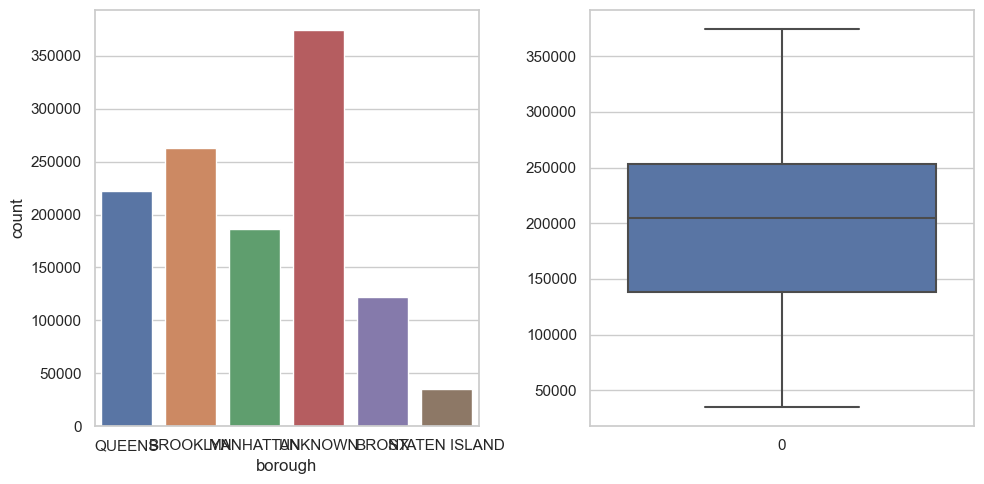

In [6]:
# Specify the path to the directory where you want to save the figure
directory_path = './explore_viz/01_univariate_viz/'

# create visuals for each continuous varable
for ele in categorical_col:
    print(ele.upper())
    print(train[ele].describe())
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    # first plot
    sns.countplot(data=train, x = ele, ax=ax[0])
    
    # secondplot
    sns.boxplot(train[ele].value_counts(), ax=ax[1])
    
    plt.tight_layout()
    
    explore_.save_visuals()
    plt.show()

In [ ]:
vehicle_type_code = pd.DataFrame(train.vehicle_type_code_1.value_counts())
vehicle_type_code
# vehicle_type_code[["count"]] = vehicle_type_code

**Continuous variables**

Here I will use hitograms, and kernel density plot to my continious variables with added discriptive statistics to help me identify

- The shape of my distributon, peaks and modes, outliets and imbalance in my data.

In [ ]:
# create visuals for each continuous varable
for ele in continuous_col:
    print(ele.upper())
    print(train[ele].describe())
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    # first plot
    sns.histplot(train[ele], ax=ax[0])
    
    # second plot
    sns.kdeplot(train[ele], ax=ax[1])
    
    plt.tight_layout()
    explore_.save_visuals(fig, viz_name= ele, 1)
    plt.show()

## Bivariate Stats

# Multivariate Stats